In [1]:
# !pip install sklearn

# 案例介绍：<br>
本案例通过对多导睡眠图（Polysomnography,PSG）数据进行睡眠阶段的分类来判断睡眠类型。<br>
训练：对Alice的睡眠数据进行训练；<br>
测试：利用训练结果对Bob的睡眠数据进行测试，判断其睡眠类型。<br>
在分析之前，先简单介绍一下多导睡眠图<br>
多导睡眠图（Polysomnography,PSG）又称睡眠脑电图。<br>
主要用于睡眠和梦境研究以及抑郁症和睡眠呼吸暂停综合征的诊断。<br>
多导睡眠图是通过不同部位的生物电或通过不同传感获得生物讯号，经前置放大，输出为不同的电讯号，记录出不同的图形以供分析。<br>
<br>
##  数据集介绍：<br>
本案例用的数据是来自于PhysioNet上关于健康受试者的年龄对睡眠影响研究的公开数据集的一个子集。<br>
mne.datasets.sleep_physionet.age.fetch_data可以下载PhysioNet数据集的子数据集。<br>
该子数据集中包含20位受试者的实验数据，记录当时年龄为25-34岁的10位男性和10位女性的实验数据。<br>
由于受试者13的第二个记录遗失了，所以除了受试者13以外，每个受试者都有两次夜间记录。<br>

Sleep Physionet数据集使用8个标签进行标注，代表8各阶段：<br>
Wake (W),<br>
Stage 1,<br>
Stage 2,<br>
Stage 3,<br>
Stage 4,<br>
REM(R),<br>
Movement time(M),<br>
Stage(?). Stage(?)-(not scored)  <br>
唤醒-Wake(W)、第1阶段、第2阶段、第3阶段、第4阶段、对应于从轻度睡眠到深度睡眠的范围；<br>
REM睡眠（R），其中REM是Rapid Eye的缩写，表示快速眼运动睡眠，运动（M）和阶段(?)的任何未得分部分。<br>

In [2]:
# 第一步：导入工具库

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\zx305\mne_data\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


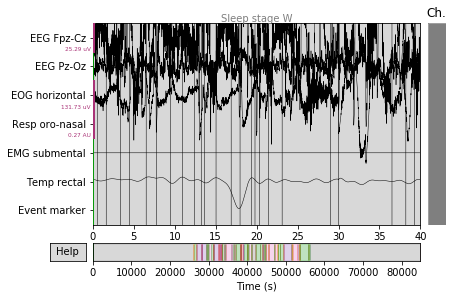

In [3]:
# 第二步：加载数据
# 在这里，我们从两个主题下载数据，最终目标是获得时间片段(epochs)及其相关的地面真理。

# MNE-Python为我们提供了mne.datasets.sleep_physionet.age.fetch_data()，
# 可以方便地从Sleep Physionet数据集下载数据。  
# 给定主题和记录的列表，提取程序将下载数据并为每个主题提供数据， 一对文件：
# -PSG.edf包含多导睡眠图。来自EEG头盔的原始数据，
# -Hypnogram.edf包含专家记录的注释。

# 然后，将这两个对象合并到mne.io.Raw对象中，就可以根据注释的描述提取事件以获得时间片段(epochs)。


"""

可以通过
mne.datasets.sleep_physionet.age.fetch_data(subjects,recording,path)
来获取PhysioNet多导睡眠图数据集文件。

subjects：表示想要使用哪些受试者对象，可供选择的受试者对象范围为0-19。

recording：表示夜间记录的编号(索引)，有效值为：[1]、[2]或[1、2]。

path:PhysioNet数据的存放地址，如果没有给定，则加载默认存放数据的地址；

如果默认存放数据集的地址不存在数据，则从网络中下载相关数据。

"""


# 选择两个受试者实验对象ALICE, BOB(该名字并非实验中的真实名，这里是为了方便才临时取的名字)

ALICE, BOB = 0, 1 #可以这么赋值

# 加载ALICE, BOB的实验数据文件

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[2])

# 通道名称映射

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc', 
          'EMG submental': 'misc', 
          'Temp rectal': 'misc', 
          'Event marker': 'misc'}

#读取ALICE的edf文件，和其对应的注释文件
raw_train = mne.io.read_raw_edf(alice_files[0])
annot_train = mne.read_annotations(alice_files[1])
raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)
# 绘制空0s开始，时间窗口长度为40s的连续通道数据波形图
raw_train.plot(duration=40, scalings='auto')
plt.show()

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\zx305\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


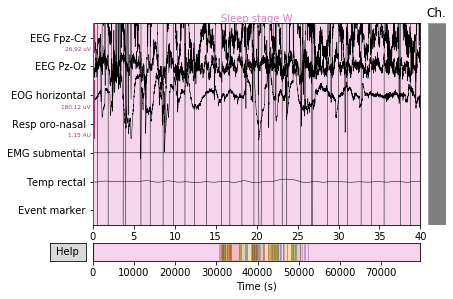

In [4]:
[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

# 通道名称映射

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc', 
          'EMG submental': 'misc', 
          'Temp rectal': 'misc', 
          'Event marker': 'misc'}

#读取ALICE的edf文件，和其对应的注释文件
raw_train = mne.io.read_raw_edf(alice_files[0])
annot_train = mne.read_annotations(alice_files[1])
raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)
# 绘制空0s开始，时间窗口长度为40s的连续通道数据波形图
raw_train.plot(duration=40, scalings='auto')
plt.show()

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


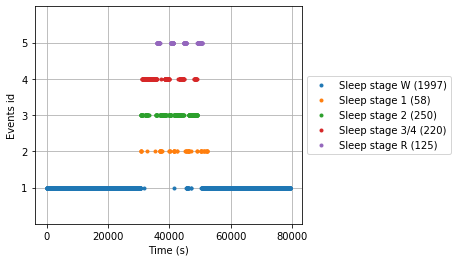

In [5]:
# 这里仅使用5个阶段：唤醒（W），阶段1，阶段2，阶段3/4和REM睡眠(R)。 
# 为此，这里使用mne.events_from_annotations()中的event_id参数来选择我们感兴趣的事件，
# 并将事件标识符与每个事件相关联。


"""睡眠表示与事件映射"""

annotation_desc_2_event_id = {'Sleep stage W': 1, 
                             'Sleep stage 1': 2, 
                             'Sleep stage 2': 3, 
                             'Sleep stage 3': 4, 
                             'Sleep stage 4': 4, 
                             'Sleep stage R': 5}
events_train, _ = mne.events_from_annotations(raw_train,
                                              event_id=annotation_desc_2_event_id,
                                              chunk_duration=30.)
# 创建一个新的event_id以统一 阶段3和4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2, 
           'Sleep stage 2': 3,   
         'Sleep stage 3/4': 4, 
           'Sleep stage R': 5}
# 绘制事件数据
mne.viz.plot_events(events_train,
                    event_id=event_id,
                    sfreq=raw_train.info['sfreq'])
# 保留颜色代码以便进一步绘制
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [6]:
# 根据注释中的事件从数据创建epochs(时间片段)


tmax = 30. - 1. / raw_train.info['sfreq']  
# tmax in included

"""
所创建的是时间从tmin=0开始，到tmax为止的epochs
"""
epochs_train = mne.Epochs(raw=raw_train, 
                          events=events_train, 
                         event_id=event_id,
                          tmin=0.,
                          tmax=tmax, 
                          baseline=None)
print(epochs_train)


2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2650 events (good & bad), 0 - 29.99 sec, baseline off, ~19 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 1997>


In [7]:
# 第三步：加载Bob的数据作为测试数据
# 按照上述相同的步骤来获取Bob的测试数据

raw_test = mne.io.read_raw_edf(bob_files[0])
annot_test = mne.read_annotations(bob_files[1])
raw_test.set_annotations(annot_test,
                         emit_warning=False)
raw_test.set_channel_types(mapping)
events_test, _ = mne.events_from_annotations(raw_test,
                                             event_id=annotation_desc_2_event_id,
                                             chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test,
                         events=events_test,
                         event_id=event_id, 
                        tmin=0.,
                         tmax=tmax,
                         baseline=None)
print(epochs_test)

Extracting EDF parameters from C:\Users\zx305\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2802 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2802 events (good & bad), 0 - 29.99 sec, baseline off, ~19 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 1856>


Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1997 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS 

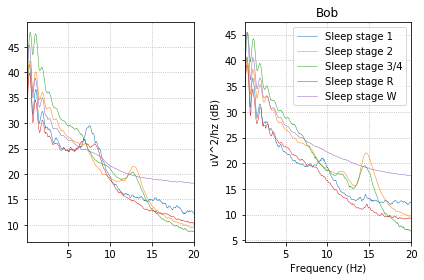

In [8]:
# 特征工程
# 观察不同睡眠阶段的功率谱密度(PSD)图，可以看到不同睡眠阶段具有不同的特征。
# 这些签名在Alice和Bob的数据中保持相似。

# 在本节的其余部分中，将基于特定频带中的相对功率来创建EEG特征，以捕获数据中睡眠阶段之间的差异。

fig, (ax1, ax2) = plt.subplots(ncols=2)
# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], 
                            ['Alice', 'Bob'], 
                            [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors): 
        epochs[stage].plot_psd(area_mode=None,
                               color=color, ax=ax,
                               fmin=0.1, 
                               fmax=20.,
                               show=False, 
                               average=True,
                               spatial_colors=False)
ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='uV^2/hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.tight_layout()
plt.show()


In [9]:
# 第四步：设计scikit-learn 转换器
# 创建一个函数，根据特定频带中的相对功率提取脑电图特征，从而能够根据脑电图信号预测睡眠阶段。
# 	• 
# 	• 
"""
脑电相对功率带特征提取
该函数接受一个""mne.Epochs"对象，
并基于与scikit-learn兼容的特定频带中的相对功率创建EEG特征。
Parameters    ----------    epochs : Epochs
The data.
Returns    -------    X : numpy array of shape
[n_samples, 5]        Transformed data.    
"""
def eeg_power_band(epochs):

    # 特定频带
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}
    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)   
 # 归一化 PSDs
    psds /= np.sum(psds,
                   axis=-1,
                   keepdims=True)
    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))
        return np.concatenate(X, axis=1)


In [10]:
# 第五步：根据 Alice的数据来预测Bob的睡眠阶段 

# 使用scikit-learn进行多分类
# 下面展示了解决如何从爱丽丝的数据中预测鲍勃的睡眠阶段并尽可能避免重复样板代码的问题。
# 这里将利用sckit-learn的Pipeline和FunctionTransformer。

#  扩展：[Pipeline可以将许多算法模型串联起来，
# 可以用于把多个estamitors级联成一个estamitor,
# 比如将特征提取、归一化、分类组织在一起形成一个典型的机器学习问题工作流。
# FunctionTransformer将python函数转换为与estamitor兼容的对象。]

pipe = make_pipeline(
                    FunctionTransformer(eeg_power_band,
                                         validate=False),
                     RandomForestClassifier(n_estimators=100,
                                            random_state=42)
                    )
# 训练
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)
# 预测
y_pred = pipe.predict(epochs_test)
# 评估准确率
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(acc))


Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Loading data for 2802 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.7676659528907923


In [11]:
# 案例上的结果是84.7 为什么这边小下去了？

In [12]:
# 预测的准确精度为84.7%
# 查看分类报告做进一步分析
# 	• 
print(classification_report(y_test, 
                            y_pred,
                            target_names=event_id.keys()))


                 precision    recall  f1-score   support

  Sleep stage W       0.81      0.99      0.89      1856
  Sleep stage 1       0.12      0.01      0.02       109
  Sleep stage 2       0.69      0.39      0.50       562
Sleep stage 3/4       0.49      0.70      0.58       105
  Sleep stage R       0.40      0.16      0.23       170

       accuracy                           0.77      2802
      macro avg       0.50      0.45      0.44      2802
   weighted avg       0.72      0.77      0.73      2802



In [13]:
# 从分类报告中可以看出，
# Bob的每个阶段训练测试样本，以及对应的睡眠阶段的精度。
# 比如W阶段的精度为86%,测试样本为1856。测试总样本为2802。
# 也可以看到其他一些指标比如召回率和F1值。这些指标的含义以后介绍。